<a href="https://colab.research.google.com/github/sahilfaizal01/Analysing-Top-Productivity-Tools-on-Google-Play-Store/blob/main/Data_Collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**


In [1]:
!pip install -qq google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00


In [2]:
!pip install -qq -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas             : 2.1.4
matplotlib         : 3.7.1
seaborn            : 0.13.1
google_play_scraper: 1.2.7



In [4]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# **Downloading data from Top 25 productivity tools**

In [34]:
app_packages = [
  'com.todoist',
  'com.trello',
  'com.microsoft.todos',
  'com.ticktick.task',
  'com.anydo',
  'com.evernote',
  'com.google.android.keep',
  'cc.forestapp',
  'notion.id',
  'com.microsoft.office.onenote',
  'co.pixo.apps.focuskeeper',
  'com.rescuetime.android',
  'com.toggl.giskard',
  'me.clockify.android',
  'com.google.android.calendar',
  'com.microsoft.office.outlook',
  'com.google.android.apps.tasks',
  'com.amazon.kindle',
  'com.google.android.apps.books',
  'com.google.android.apps.docs',
  'com.microsoft.office.word',
  'biz.codespark.xcalendarapp',
  'com.dropbox.paper',
  'com.zoho.writer',
  'works.jubilee.timetree'
]

In [35]:
len(app_packages)

25

In [37]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


In [38]:
def print_json(json_object):
  json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [39]:
print_json(app_infos[0])


{
  "adSupported": false,
  "appId": "com.todoist",
  "categories": [
    {
      "id": "PRODUCTIVITY",
      "name": "Productivity"
    }
  ],
  "containsAds": false,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Trusted by over 42 million people, Todoist is a to do list and a planning center for individuals and teams. Instantly declutter your mind, boost productivity and build habits with Todoist. \r\n\r\nWith a simple tap, add your daily tasks and set reminders, enjoy multiple views like calendar, list and board, filter tasks by work and/or personal life, share notes, collaborate on projects, and achieve peace of mind. \r\n\r\nWhy choose Todoist?\r\n\u2022 As a habit tracker, you can add tasks like \u201cPlan next week\u2019s work every Friday afternoon\u201d or \u201cDo homework every Wednesday at 6pm\u201d using Todoist\u2019s powerful language recognition and recurring due dates.\r\n\u2022 Use it as a checklist to reach 

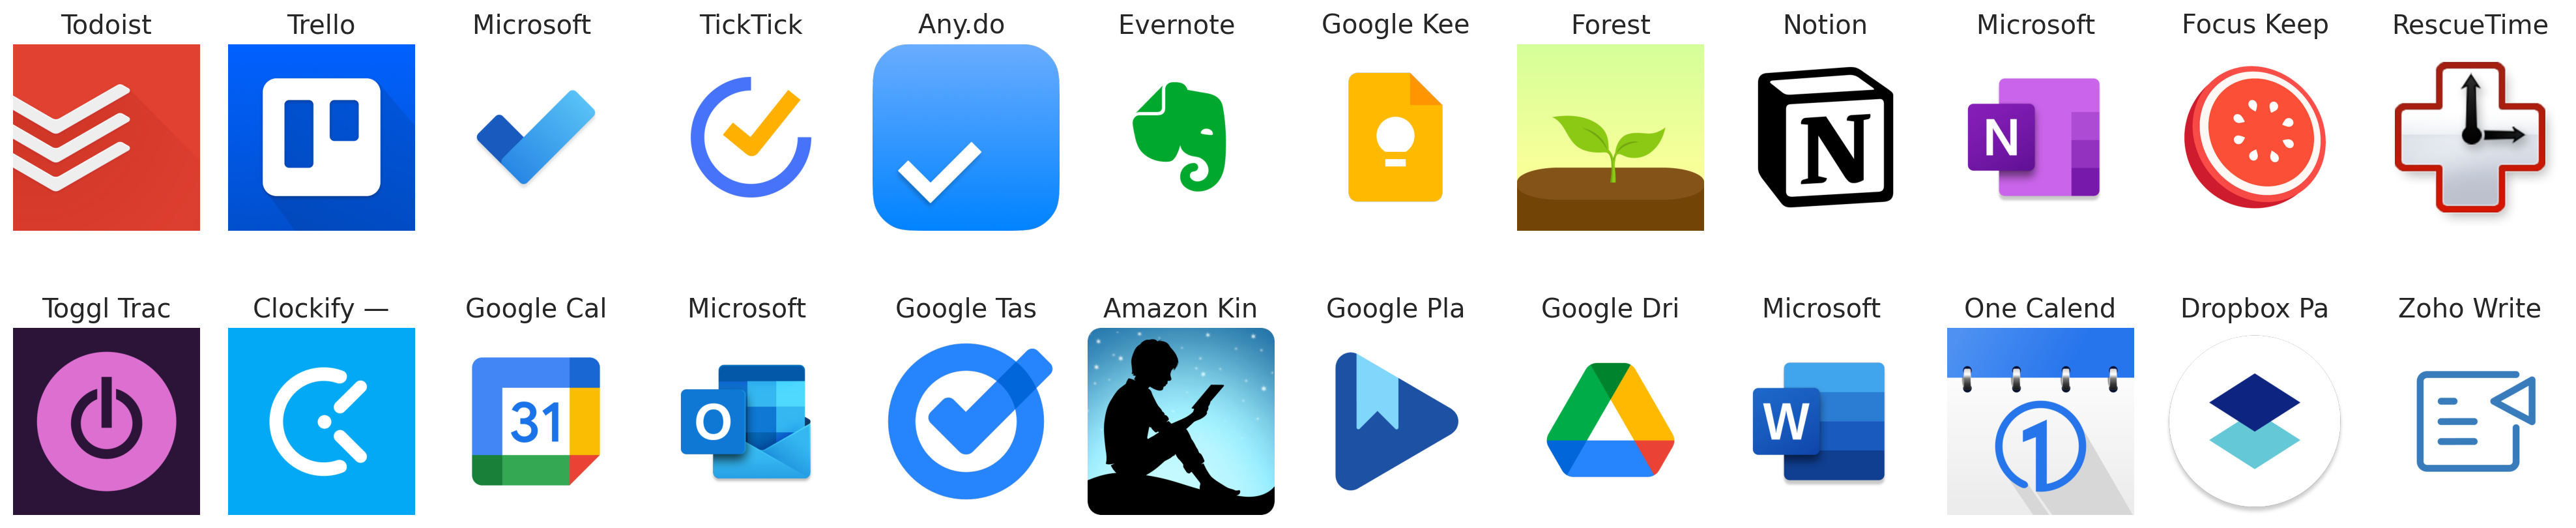

In [47]:
import urllib.request
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def format_title(title):
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    if sep_index != -1:
        title = title[:sep_index]
    return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(20, 5))

for i, ax in enumerate(axs.flat):
    ai = app_infos[i]
    url = ai['icon']

    # Open the image from the URL
    img = np.array(Image.open(urllib.request.urlopen(url)))

    ax.imshow(img)
    ax.set_title(format_title(ai['title']))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [41]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

# **Scraping App Reviews**

In [42]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 25/25 [01:00<00:00,  2.40s/it]


In [43]:
print_json(app_reviews[0])

{
  "appId": "com.todoist",
  "appVersion": "v11432",
  "at": "2024-05-23 12:01:14",
  "content": "I used this app for many years and it worked for my purposes at the time. However, sometime at the beginning of this year it began dropping the due dates on the tasks that were overdue And this was a huge problem for me. I tried to work with the developers to recover this data for months and they couldn't do it and in fact, to add insult to injury, they dropped the due dates on another month of my past due tasks without warning or explanation. This app is definitely not built for record keeping.",
  "repliedAt": "2024-05-24 15:43:43",
  "replyContent": "Hi Pat, we're truly sorry to hear about this! One of our colleagues is still in touch with you to help resolve the issue. We kindly ask if you could provide more details at your earliest convenience, so we can better understand and address the problem. Thank you for your patience and cooperation.",
  "reviewCreatedVersion": "v11432",
  "re

In [44]:
len(app_reviews)

28014

In [45]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)